In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import blip_analysis as ba
from sklearn.decomposition import PCA
from copy import deepcopy
from tqdm import trange
from matplotlib.gridspec import GridSpec
import json
from label_axes import label_axes
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

b


In [2]:
### Load in the data
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
glyphs = ba.get_glyphs()
diff_models1 = pickle.Unpickler(open('../Data/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Data/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Data/230320_diff_models3.pkl', 'rb')).load()
onset_models1 = pickle.Unpickler(open('../Data/230320_onset_models1.pkl', 'rb')).load()
conc_models1 = pickle.Unpickler(open('../Data/230320_conc_models1.pkl', 'rb')).load()
style_params = json.load(open('../Data/style_params.json', 'r'))



Found odour 1
Found odour 3
Found odour 5


In [3]:
style_params = json.load(open('../Data/style_params.json', 'r'))

In [4]:
## Extract the bins fro the models
bins1 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models1]).mean(axis=1)
bins2 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models2]).mean(axis=1)
bins3 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models3]).mean(axis=1)

all_preds = [i.pred_resp for i in diff_models1] + [i.pred_resp for i in diff_models2] + [i.pred_resp for i in diff_models3]
all_trues = [i.true_resp for i in diff_models1] + [i.true_resp for i in diff_models2] + [i.true_resp for i in diff_models3]


In [7]:
### apply PCA to the bins
pca1 = PCA(n_components=9)
fit_bins1 = pca1.fit_transform(bins1)
fit_1_pc12 = deepcopy(fit_bins1)
fit_1_pc12[:, 2:] = 0
bins_1_pc12 = pca1.inverse_transform(fit_1_pc12)


pca2 = PCA(n_components=9)
fit_bins2 = pca2.fit_transform(bins2)
fit_2_pc12 = fit_bins2.copy()
fit_2_pc12[:, 2:] = 0
bins_2_pc12 = pca2.inverse_transform(fit_2_pc12)

pca3 = PCA(n_components=9)
fit_bins3 = pca3.fit_transform(bins3)
fit_3_pc12 = fit_bins3.copy()
fit_3_pc12[:, 2:] = 0
bins_3_pc12 = pca3.inverse_transform(fit_3_pc12)

pca_all = PCA(n_components=9)
all_bins = np.concatenate([bins1 , bins2 , bins3], axis=0)
fit_bins_all = pca_all.fit_transform(all_bins)
fit_all_pc12 = fit_bins_all.copy()
fit_all_pc12[:, 2:] = 0
bins_all_pc12 = pca_all.inverse_transform(fit_all_pc12)



In [5]:
### Normalise the change in the fit error for each cell as the number of PC increases
all_normed = []
for index in trange(100):
    first_pass_bins = np.array([i.training_opts[index].x[:-1] for i in diff_models1])
    threshes = np.array([i.training_opts[index].x[-1] for i in diff_models1])
    pca = PCA(n_components=9)

    all_fit_errors = []
    all_pred_resps = []
    for pcs in range(0, 10):
        pcad_bins = pca.fit_transform(first_pass_bins)
        pcad_bins[:, pcs:] = 0
        pcad_bins = pca.inverse_transform(pcad_bins)
        [model.fit(W=i.tolist() + [j]) for model, i, j in zip(diff_models1, pcad_bins, threshes)];
        pred_resps = [i.pred_resp for i in diff_models1]
        all_pred_resps.append(pred_resps)
        fit_errors = [np.sum((i.X_test_avg[index] - j)**2) for i, j in zip(diff_models1, pred_resps)]
        all_fit_errors.append(fit_errors)
    all_fit_errors = np.array(all_fit_errors)
    all_pred_resps = np.array(all_pred_resps)
    normed =( all_fit_errors - all_fit_errors.min(axis=0)) / (all_fit_errors.max(axis=0) - all_fit_errors.min(axis=0))
    # for i in normed.T:
    #     plt.plot(i, alpha=0.5, color='lightgray')
    # plt.plot(normed.mean(axis=1))
    # plt.xlabel('Number of PCs')
    # plt.ylabel('Normalized Fit Error')
    all_normed.append(normed)


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


In [8]:
### Generate the laplace distributions along both of the PCs
pc1_exp_decay = np.abs([i - np.median(fit_bins_all[:, 0]) for i in fit_bins_all[:, 0]]).mean()
pc2_exp_decay = np.abs([i - np.median(fit_bins_all[:, 1]) for i in fit_bins_all[:, 1]]).mean()
rand1 = np.random.laplace(0, pc1_exp_decay, 10000)
rand2 = np.random.laplace(0, pc2_exp_decay, 10000)

In [24]:
def plot_heatmaps(gs):
    ''' Plot the laplace modelled, true and difference heatmaps of the data'''
    sub_gs = gs.subgridspec(1, 3)

    fig = plt.gcf()
    ax = [fig.add_subplot(sub_gs[i]) for i in range(3)]
    
    h, x, y, p  = ax[0].hist2d(rand1, rand2, bins=[np.linspace(-2.5, 2.5, 20), np.linspace(-2.5, 2.5, 20)], density=True);

    h1, x1, y1, p1 = ax[1].hist2d(fit_bins_all[:, 0], fit_bins_all[:, 1], bins=[np.linspace(-2.5, 2.5, 20), np.linspace(-2.5, 2.5, 20)], density=True);

    max_h = np.max([np.max(h), np.max(h1)])
    p1.set_clim(0, max_h)
    p.set_clim(0, max_h)
    plt.draw()

    ax[0].set_aspect('equal') 
    ax[1].set_aspect('equal')
    vmax =0.3 #¢np.max(abs(h1-h))/2
    im = ax[2].imshow(np.array(h1-h).T, cmap='bwr', vmax=vmax, vmin=-vmax, extent=[-2.5, 2.5, -2.5, 2.5], interpolation='gaussian', origin='lower')
    cbar_1 = plt.colorbar(ax=ax[1], mappable=p1, shrink=0.72)
    cbar_2 = plt.colorbar(ax=ax[2], mappable=im, shrink=0.72)
    init_ax_pos = ax[0].get_position()
    ax[0].set_position([init_ax_pos.x0, ax[1].get_position().y0, ax[1].get_position().width,  ax[1].get_position().height])
    ax[0].set_title('Laplace fit')
    ax[1].set_title('True')
    ax[2].set_title('Difference')
    ax[1].set_yticklabels([])
    ax[0].set_ylabel('PC2')
    ax[0].set_xlabel('PC1')
    ax[1].set_xlabel('PC1')
    ax[2].set_xlabel('PC1')
    ax[2].set_ylabel('PC2')
    return ax, [cbar_1, cbar_2]

In [11]:
## Find the correlation between the PCs
corrs = []
for i in range(9):
    flat_triag = np.triu(np.corrcoef([pca1.components_[i], pca2.components_[i], pca3.components_[i]]), 1).flatten()
    flat_triag = flat_triag[flat_triag != 0]
    corrs.append(flat_triag)

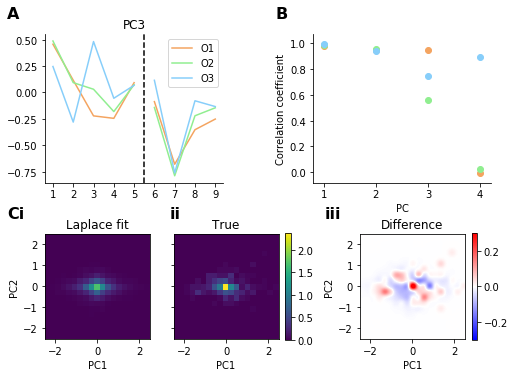

In [30]:
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2, wspace=0.5)
odour_grays = style_params['odour_colors']
odour_labels = style_params['odour_labels']
pc_ax3 = fig.add_subplot(gs[0, 0])

pc_ax3.plot(pca1.components_[2][:5], color=odour_grays[0], label=odour_labels[0])
pc_ax3.plot(pca2.components_[2][:5], color=odour_grays[1], label=odour_labels[1])
pc_ax3.plot(pca3.components_[2][:5], color=odour_grays[2], label=odour_labels[2])

pc_ax3.plot(range(5, 9), pca1.components_[2][5:], color=odour_grays[0])
pc_ax3.plot(range(5, 9), pca2.components_[2][5:], color=odour_grays[1])
pc_ax3.plot(range(5, 9), pca3.components_[2][5:], color=odour_grays[2])

pc_ax3.spines['right'].set_visible(False)
pc_ax3.spines['top'].set_visible(False)
pc_ax3.set_title(f'PC{2+1}')
pc_ax3.set_xticks(range(9))
pc_ax3.set_xticklabels(range(1,10))
pc_ax3.axvline(4.5, color='k', linestyle='--')
pc_ax3.legend()

corr_ax = fig.add_subplot(gs[0, 1])
corr_ax.scatter(range(1, 5), np.array(corrs)[:4, 0], color=odour_grays[0])
corr_ax.scatter(range(1, 5), np.array(corrs)[:4, 1], color=odour_grays[1])
corr_ax.scatter(range(1, 5), np.array(corrs)[:4, 2], color=odour_grays[2])
corr_ax.set_ylabel('Correlation coefficient')
corr_ax.set_xlabel('PC')
corr_ax.set_xticks(range(1, 5))
corr_ax.spines['right'].set_visible(False)
corr_ax.spines['top'].set_visible(False)
heatmap_axs, cbars = plot_heatmaps(gs[1, :])
hm_pos = heatmap_axs[1].get_position()
hm_pos = [hm_pos.x0-0.05, hm_pos.y0, hm_pos.width, hm_pos.height]
heatmap_axs[1].set_position(hm_pos)
cbar_pos = cbars[0].ax.get_position()
cbar_pos = [cbar_pos.x0-0.05, cbar_pos.y0, cbar_pos.width, cbar_pos.height]
cbars[0].ax.set_position(cbar_pos)
axes = [pc_ax3, corr_ax, heatmap_axs[0], heatmap_axs[1], heatmap_axs[2]]
labels = ['A', 'B', 'Ci', 'ii', 'iii']
align_x = [[0, 2]]
align_y = [[0, 1], [2, 3, 4]]
label_axes.label_axes(axes, labels, fontsize=16, fontweight='bold', align_x=align_x, align_y=align_y, align_x_fun=np.min, align_y_fun=np.max)
plt.savefig('230825_Sup51.pdf', bbox_inches='tight')


In [ ]:
corr_ax = fig.add_subplot(sub_gs[0, 2])
corr_ax.scatter(range(1, 5), np.array(corrs)[:4, 0], color=odour_grays[0])
corr_ax.scatter(range(1, 5), np.array(corrs)[:4, 1], color=odour_grays[1])
corr_ax.scatter(range(1, 5), np.array(corrs)[:4, 2], color=odour_grays[2])
corr_ax.set_ylabel('Correlation coefficient')
corr_ax.set_xlabel('PC')
corr_ax.set_xticks(range(1, 5))
corr_ax.spines['right'].set_visible(False)
corr_ax.spines['top'].set_visible(False)